In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle

# aes
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':12})
# rc('text', usetex=True)

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [2]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [3]:
# load questions (to be removed)

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [4]:
!ls 

1800.pickle                          prompt100tablellama.py
644sample-multi                      prompt_wip.py
644sample-multi-logitlens            prompt_wip_sel.bak.py
README.md                            prompt_wip_sel.py
TableLlama.2073770127.pickle         runner.py
TableLlama.3729511693.pickle         select_errors_from_1800.ipynb
aggrodue.pickle                      selected_pids.644.pickle
backup                               selected_pids.688.pickle
cohesion.ipynb                       tablellama-classifier-ag.ipynb
cohesion.pickle                      tablellama-classifier.ipynb
delme.xlsx                           tablellama-high
gemma-2-2b-it.3892595837.pickle      tablellama-multipass.ipynb
gemma-2-9b-it-4bit.3246737286.pickle tablellama-plot copy.ipynb
jensension.ipynb                     tablellama-plot.ipynb
logits-tablellama.ipynb              tablellama-regr-good
mirror                               tablellama-regressor-ag.ipynb
older tablellama                     ta

In [5]:
!ls ./644sample-multi-logitlens/

TableLlama.1175269542.pickle


In [6]:
%%time

# load processed data

import os
import pickle
from copy import deepcopy

prefix = './644sample-multi-logitlens/' # runs on 344 prompts with at least 1 error and 344 prompts with no error

run = 0
outlist = []

for file in os.listdir(prefix):
    if file.endswith('pickle'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
            for pid, item in enumerate(tqdm(outlist_)):
                # explode multiruns
                for i, _ in enumerate(item["post_output_sequences"]):
                    item_ = deepcopy(item)
                    item_["post_output_sequences"] = item["post_output_sequences"][i]
                    item_["post_output_proba_topn"] = item["post_output_proba_topn"][i]
                    item_["post_output_proba_topk"] = item["post_output_proba_topk"][i]
                    item_["post_output_true_entropies"] = item["post_output_true_entropies"][i] 
                    
                    item_["post_output_layers_kl"] = item["post_output_layers_kl"][i]
                    item_["post_output_layers_iou"] = item["post_output_layers_iou"][i]
                    item_["transition_scores_s"] = item["transition_scores_s"][i]
                    item_["transition_scores_l"] = item["transition_scores_l"][i]
                    
                    item_["run"] = run + i

                    outlist.append(item_)
            run = run + i + 1 # next file

len(outlist)

TableLlama.1175269542.pickle


100%|█████████████████████████████████████████| 509/509 [08:53<00:00,  1.05s/it]

CPU times: user 54min 31s, sys: 7min 32s, total: 1h 2min 4s
Wall time: 9min 2s


5090

In [7]:
len(outlist_), len(outlist), outlist[-1]['run']

(509, 5090, 9)

### check output against ground truth

In [8]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

for idx, p in enumerate(outlist):
    print(idx, end='\r')
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    
    # replacement due to tablellama "hallucinations"
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    hallucinated = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct, hallucinated))
    outseq.append((p['run'], p['pid'], generated_text, post_output_sequences, b))

CPU times: user 40.1 s, sys: 1.31 s, total: 41.4 s
Wall time: 43.2 s


In [9]:
# true, hallucinated, counted
t, h, c

(3668, 23, 5090)

In [10]:
# true, hallucinated, counted
t, h, c

(3668, 23, 5090)

In [11]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated'])

In [12]:
truth.describe(include='all')

,run,pid,correct,hallucinated
count,5090.000000,5090.000000,5090,5090
unique,NaN,NaN,2,2
top,NaN,NaN,True,False
freq,NaN,NaN,3668,5067
mean,4.500000,912.117878,NaN,NaN
std,2.872564,501.001267,NaN,NaN
min,0.000000,12.000000,NaN,NaN
25%,2.000000,476.000000,NaN,NaN
50%,4.500000,913.000000,NaN,NaN
75%,7.000000,1356.000000,NaN,NaN


<Axes: xlabel='correct', ylabel='Count'>

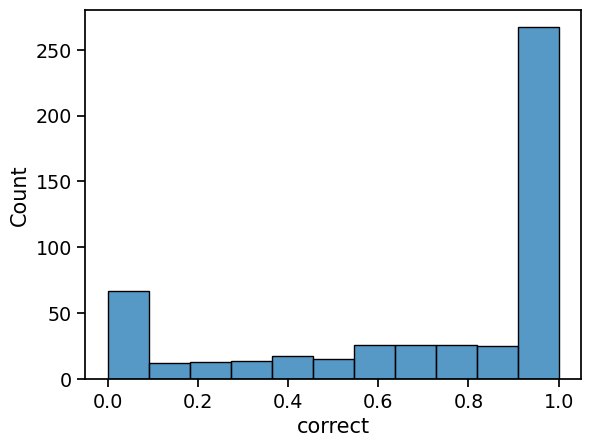

In [13]:
corec = truth.groupby('pid').correct.mean()
sns.histplot(corec, bins=corec.nunique())

<Axes: xlabel='hallucinated', ylabel='Count'>

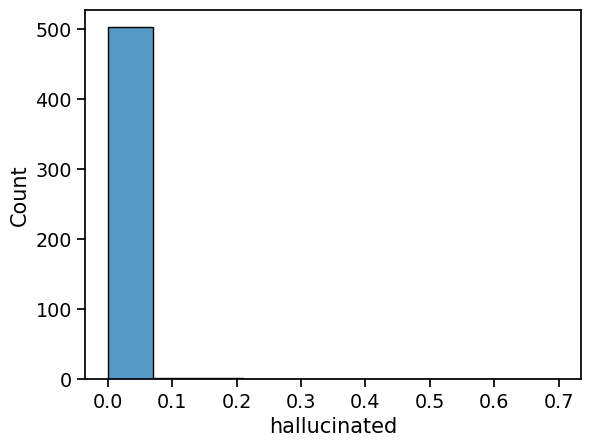

In [14]:
sns.histplot(truth.groupby('pid').hallucinated.mean())

In [15]:
truth.groupby('pid').size().value_counts()

10    509
Name: count, dtype: int64

In [16]:
truth

,run,pid,correct,hallucinated
0,0,12,False,False
1,1,12,False,False
2,2,12,False,False
3,3,12,False,False
4,4,12,True,False
...,...,...,...,...
5085,5,1794,True,False
5086,6,1794,True,False
5087,7,1794,True,False
5088,8,1794,True,False


In [17]:
accu = truth.groupby('pid').correct.mean()

In [18]:
accu[accu<1.].shape

(242,)

In [19]:
accu.value_counts()

correct
1.0    267
0.0     67
0.6     26
0.8     26
0.7     26
0.9     25
0.4     18
0.5     15
0.3     14
0.2     13
0.1     12
Name: count, dtype: int64

In [20]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer'])
answers.answer = answers.answer.str[:-1]

In [21]:
answers[answers.pid==112]

,run,pid,answer,answer_seq,right_answer
240,0,112,Asolo [DESC] Italian comune [TYPE] comune of I...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
241,1,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
242,2,112,Chile [DESCRIPTION] country in South America [...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
243,3,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
244,4,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
245,5,112,Chile [DESCRIPTION] country in South America [...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
246,6,112,Chile [DESCRIPTION] country in South America [...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
247,7,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
248,8,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
249,9,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...


### sequence components alignment
### (build "segments" for each sequence)

In [22]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [23]:
%%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])

    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    output_seq = p['post_output_sequences'][0]

    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq), len(output_seq) -1, 'generated')) # assume everything else is generated

CPU times: user 1min 24s, sys: 584 ms, total: 1min 25s
Wall time: 1min 25s


In [24]:
# check the checks (must be False)
'False' in checks

False

In [25]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [26]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [27]:
segments['length'] = segments.end - segments.start

In [28]:
segments

,run,pid,start,end,segment,seq,length
0,0,12,0,40,preamble,0,40
1,0,12,41,135,instruction,1,94
2,0,12,136,762,input,2,626
3,0,12,763,2004,question,3,1241
4,0,12,2005,2069,postilla,4,64
...,...,...,...,...,...,...,...
30535,9,1794,41,135,instruction,1,94
30536,9,1794,136,719,input,2,583
30537,9,1794,720,2015,question,3,1295
30538,9,1794,2016,2080,postilla,4,64


### segment description

In [29]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.000000,0.000000,40,40,0.015956,0.015956
2,instruction,1,94.000000,0.000000,94,94,0.037498,0.053454
1,input,2,1041.836935,663.006122,141,3643,0.415599,0.469053
5,question,3,1242.351670,305.641307,79,2325,0.495586,0.964639
3,postilla,4,64.000000,0.000000,64,64,0.025530,0.990169
0,generated,5,24.644794,5.831858,13,56,0.009831,1.000000


<Axes: xlabel='length', ylabel='Count'>

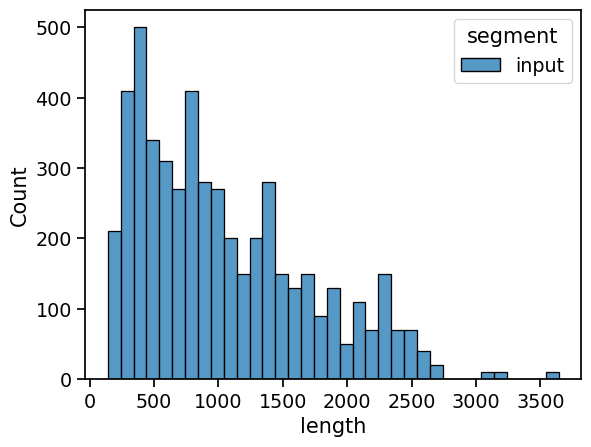

In [30]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

<Axes: xlabel='length'>

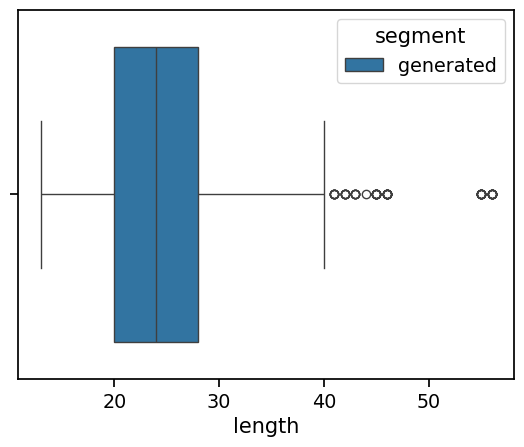

In [31]:
sns.boxplot(segments[segments.segment=='generated'], x='length', hue='segment')

<Axes: xlabel='segment', ylabel='length'>

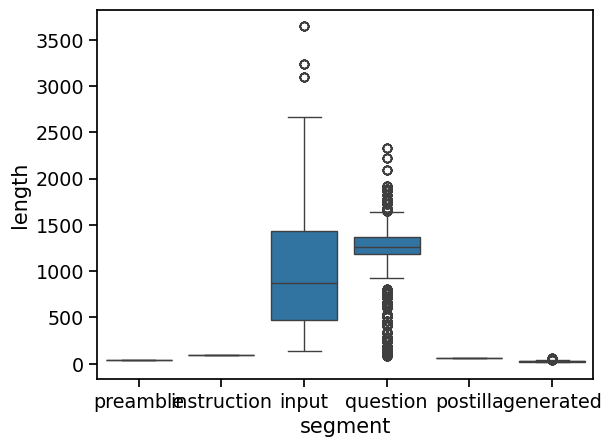

In [32]:
sns.boxplot(segments, y='length', x='segment')

In [33]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

### collect observables

In [125]:
outlist[0].keys()

dict_keys(['table', 'cell', 'instruction', 'input', 'question', 'output', 'elapsed_pre', 'pre_output_proba_topn', 'pre_output_proba_topk', 'pre_output_true_entropies', 'post_output_sequences', 'post_output_proba_topn', 'post_output_proba_topk', 'post_output_true_entropies', 'post_output_layers_kl', 'post_output_layers_iou', 'transition_scores_s', 'transition_scores_l', 'elapsed', 'pid', 'run'])

In [ ]:
# outlist[0]['post_output_layers_iou'] ha dimensione n layer x m token generati
# outlist[0]['transition_scores_s'] ha dimensione m token generati

In [147]:
len(hh), len(hh[0])

(26, 32)

In [145]:
len(outlist[0]['post_output_layers_iou'])

32

In [135]:
len(outlist[0]['transition_scores_s']), len(outlist[0]['transition_scores_l'])

(26, 26)

In [148]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    
    # append all forward data
    for j, pp in enumerate(p['pre_output_proba_topn']):
        shapes.append((run,pid,j,'prompt',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][j],
                           max(pp['top_n_probs']),
                           None,
                           None,
                           None,
                           None))
    
    # append all generation data
    transpose_kl = list(map(list, zip(*p['post_output_layers_kl'])))
    transpose_iou = list(map(list, zip(*p['post_output_layers_iou'])))
    
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs']),
                           p['transition_scores_s'][jj],
                           p['transition_scores_l'][jj],
                           transpose_kl[jj],
                           transpose_iou[jj]))

CPU times: user 11.3 s, sys: 549 ms, total: 11.9 s
Wall time: 11.9 s


In [149]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp', 'trans_s', 'trans_l', 'logitlens_kl', 'logitlens_iou'])

CPU times: user 8.36 s, sys: 941 ms, total: 9.3 s
Wall time: 9.36 s


In [150]:
d

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou
0,0,12,0,prompt,19127,9.342692e+00,0.011505,NaN,NaN,None,None
1,0,12,1,prompt,4954,6.863560e+00,0.110962,NaN,NaN,None,None
2,0,12,2,prompt,9,1.748911e+00,0.684082,NaN,NaN,None,None
3,0,12,3,prompt,178,4.617726e+00,0.093811,NaN,NaN,None,None
4,0,12,4,prompt,5,1.100033e+00,0.811523,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...
12790317,9,1794,2101,generated,1,2.413767e-07,1.000000,0.0,0.000000e+00,"[6.203125, 5.0703125, 6.8320312, 7.3007812, 9....","[7.538635506973238e-05, 8.125457056959453e-05,..."
12790318,9,1794,2102,generated,1,6.011833e-07,1.000000,0.0,0.000000e+00,"[10.3828125, 8.7734375, 7.445312, 7.316406, 6....","[0.00011760555098200635, 9.670244657189827e-05..."
12790319,9,1794,2103,generated,1,3.359786e-06,1.000000,0.0,-1.192093e-07,"[0.662596, 0.15637055, 0.6796858, 1.7333965, 3...","[0.00016299918500407498, 0.0036101083032490976..."
12790320,9,1794,2104,generated,1,1.075896e-06,1.000000,0.0,0.000000e+00,"[9.6328125, 8.9375, 8.671875, 8.21875, 8.71093...","[9.004952723998198e-05, 0.00010294420424130121..."


In [153]:
d.logitlens_iou.str.len().unique()

array([nan, 32.])

In [154]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

True

In [155]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

,run,pid,tok,shape,true_ent,maxp,trans_s,trans_l
count,50900.00000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,0.0,0.0
mean,4.50000,912.117878,2481.688605,6.285265,0.600783,0.841798,NaN,NaN
std,2.87231,500.956971,700.026409,24.805963,0.934442,0.239032,NaN,NaN
min,0.00000,12.000000,488.000000,1.000000,0.000000,0.106750,NaN,NaN
25%,2.00000,476.000000,1943.000000,1.000000,0.000108,0.712402,NaN,NaN
50%,4.50000,913.000000,2361.000000,1.000000,0.016526,0.998535,NaN,NaN
75%,7.00000,1356.000000,2946.000000,2.000000,0.898840,1.000000,NaN,NaN
max,9.00000,1794.000000,4080.000000,482.000000,5.031992,1.000000,NaN,NaN


In [156]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

,run,pid,tok,shape,true_ent,maxp,trans_s,trans_l
count,50900.00000,50900.000000,50900.000000,50900.000000,5.090000e+04,50900.000000,50900.000000,5.090000e+04
mean,4.50000,912.117878,2491.688605,1.058134,4.192411e-02,0.984264,-0.027677,-3.070105e-02
std,2.87231,500.956971,700.026409,0.323630,1.656193e-01,0.071005,0.173841,1.781271e-01
min,0.00000,12.000000,498.000000,1.000000,6.144181e-10,0.224911,-3.988493,-4.095000e+00
25%,2.00000,476.000000,1953.000000,1.000000,5.828703e-07,0.999941,0.000000,-5.948367e-05
50%,4.50000,913.000000,2371.000000,1.000000,9.642691e-06,0.999999,0.000000,-5.960463e-07
75%,7.00000,1356.000000,2956.000000,1.000000,7.031236e-04,1.000000,0.000000,0.000000e+00
max,9.00000,1794.000000,4090.000000,10.000000,2.319561e+00,1.000000,0.000000,0.000000e+00


In [157]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
m = m[(m.start <= m.tok) & (m.tok <= m.end)]

CPU times: user 8.6 s, sys: 4.72 s, total: 13.3 s
Wall time: 15.3 s


In [158]:
m

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length
0,0,12,0,prompt,19127,9.342692e+00,0.011505,NaN,NaN,None,None,0,40,preamble,0,40
6,0,12,1,prompt,4954,6.863560e+00,0.110962,NaN,NaN,None,None,0,40,preamble,0,40
12,0,12,2,prompt,9,1.748911e+00,0.684082,NaN,NaN,None,None,0,40,preamble,0,40
18,0,12,3,prompt,178,4.617726e+00,0.093811,NaN,NaN,None,None,0,40,preamble,0,40
24,0,12,4,prompt,5,1.100033e+00,0.811523,NaN,NaN,None,None,0,40,preamble,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76741907,9,1794,2101,generated,1,2.413767e-07,1.000000,0.0,0.000000e+00,"[6.203125, 5.0703125, 6.8320312, 7.3007812, 9....","[7.538635506973238e-05, 8.125457056959453e-05,...",2081,2105,generated,5,24
76741913,9,1794,2102,generated,1,6.011833e-07,1.000000,0.0,0.000000e+00,"[10.3828125, 8.7734375, 7.445312, 7.316406, 6....","[0.00011760555098200635, 9.670244657189827e-05...",2081,2105,generated,5,24
76741919,9,1794,2103,generated,1,3.359786e-06,1.000000,0.0,-1.192093e-07,"[0.662596, 0.15637055, 0.6796858, 1.7333965, 3...","[0.00016299918500407498, 0.0036101083032490976...",2081,2105,generated,5,24
76741925,9,1794,2104,generated,1,1.075896e-06,1.000000,0.0,0.000000e+00,"[9.6328125, 8.9375, 8.671875, 8.21875, 8.71093...","[9.004952723998198e-05, 0.00010294420424130121...",2081,2105,generated,5,24


In [159]:
# did we merge all the tokens to their segments (must be True)
d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

True

In [160]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

In [161]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

### check variances

In [162]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [163]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [164]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [165]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [166]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.29601318

In [167]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.033257574

In [168]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

7.778017e-08

In [169]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

4.913732e-14

In [170]:
if True:
    myoutdict = {'truth': truth, 'segments': segments, 'm': m, 'answers': answers}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [171]:
!ls -larth | grep preprocessed

-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--   1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--@  1 bono  staff   1.8G Mar 24 11:56 preprocessed.pickle


## Load preprocessed

In [57]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [58]:
m

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,12,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,12,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,12,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,12,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,12,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76741907,9,1794,2101,generated,1,2.413767e-07,1.000000,2081,2105,generated,5,24,0.998100,5.833333,20,-5
76741913,9,1794,2102,generated,1,6.011833e-07,1.000000,2081,2105,generated,5,24,0.998575,5.875000,21,-4
76741919,9,1794,2103,generated,1,3.359786e-06,1.000000,2081,2105,generated,5,24,0.999050,5.916667,22,-3
76741925,9,1794,2104,generated,1,1.075896e-06,1.000000,2081,2105,generated,5,24,0.999525,5.958333,23,-2


In [59]:
m.area.unique()

array(['prompt', 'generated'], dtype=object)

In [60]:
mm = m.copy()

### single run plots

In [61]:
m = mm[mm.run==0].copy()

In [62]:
NUM_BINS = 100

99


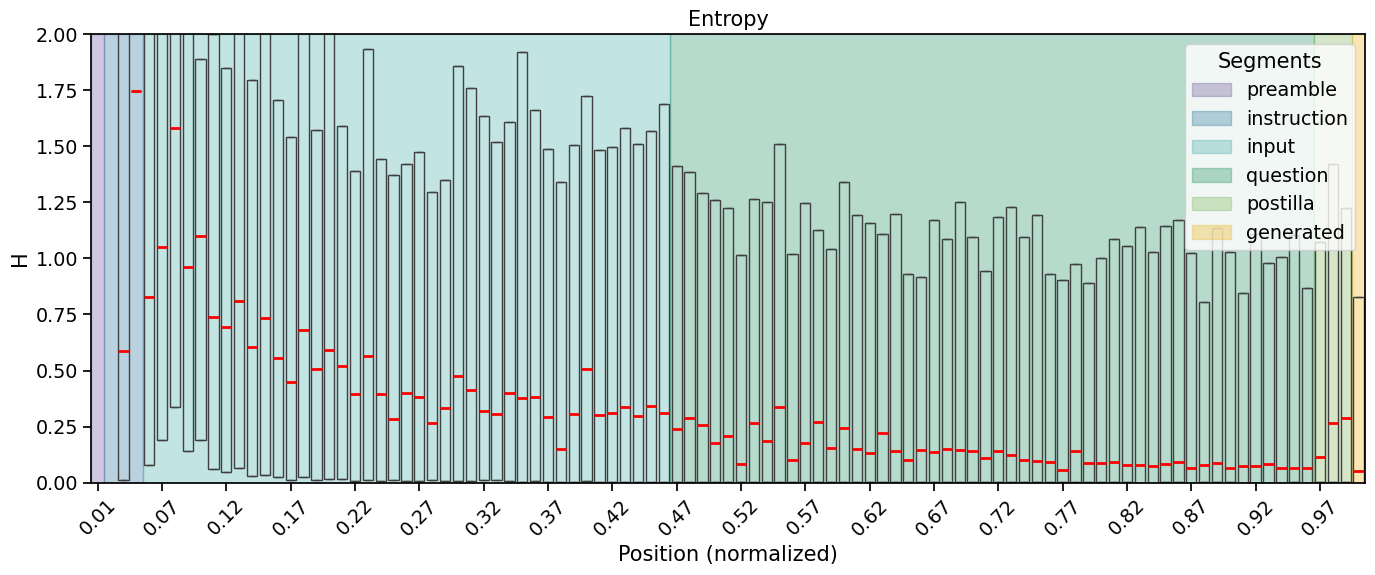

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [64]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

100


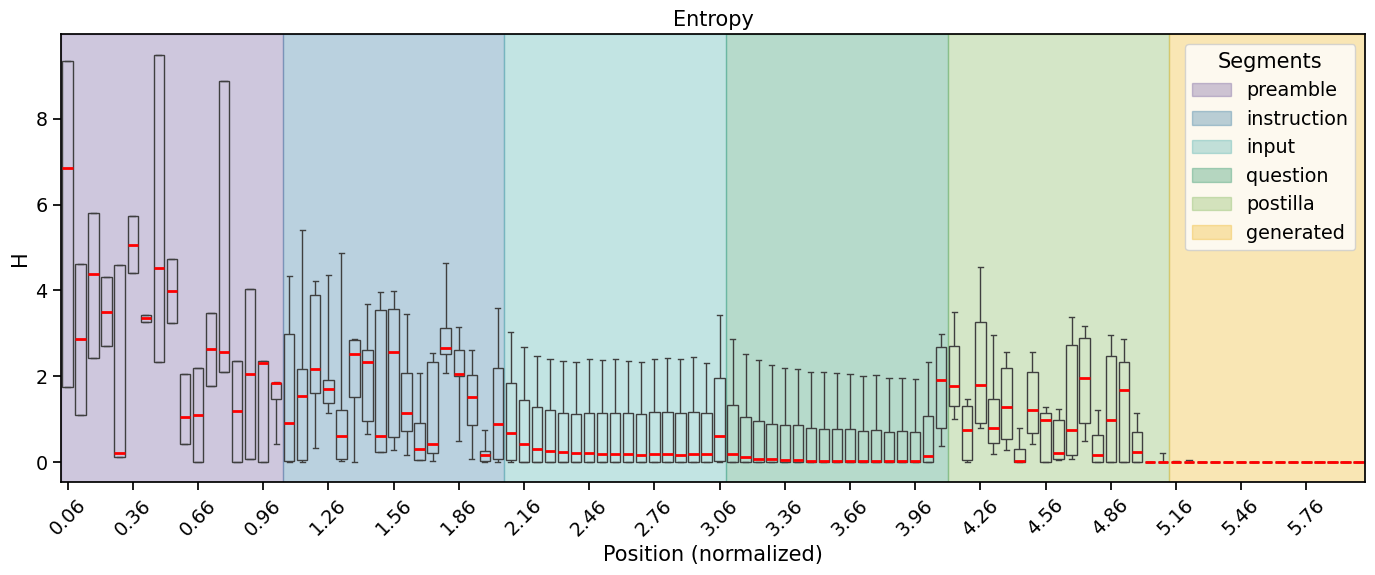

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [66]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

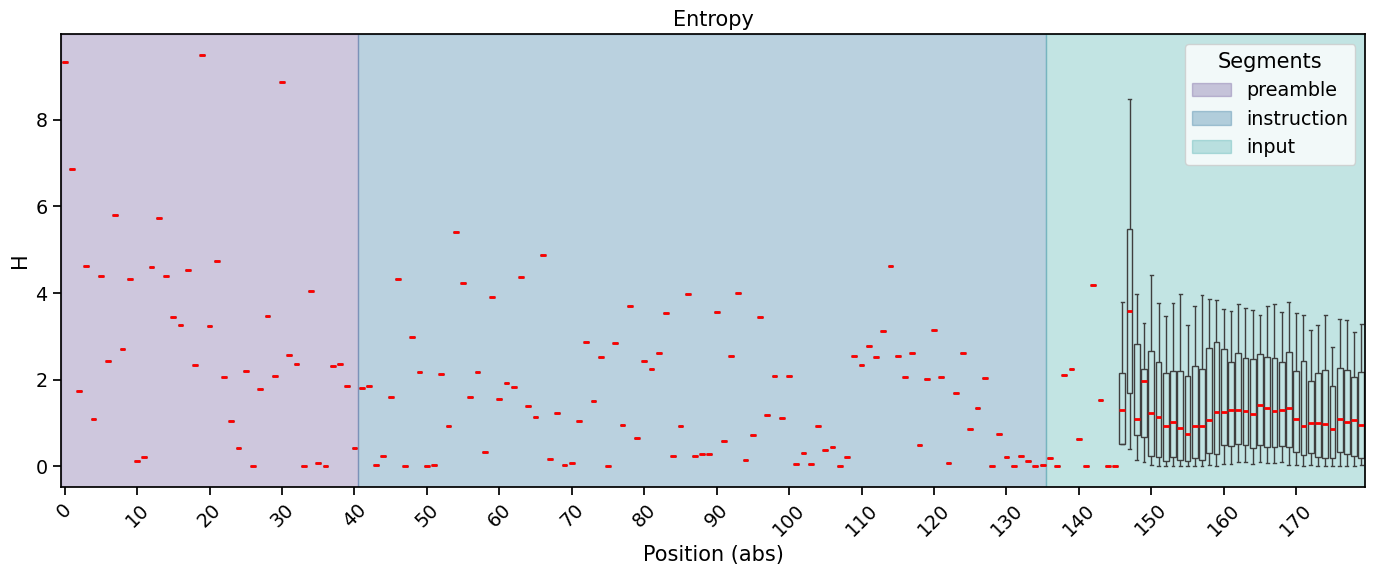

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [68]:
segments.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [69]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

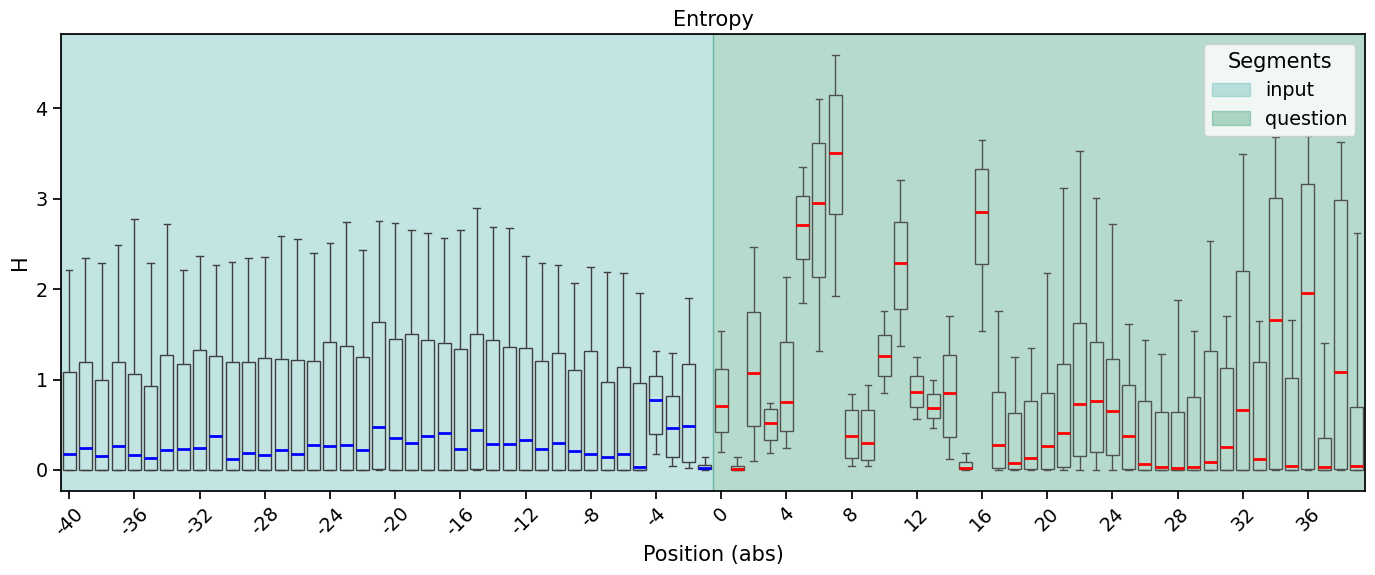

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [71]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

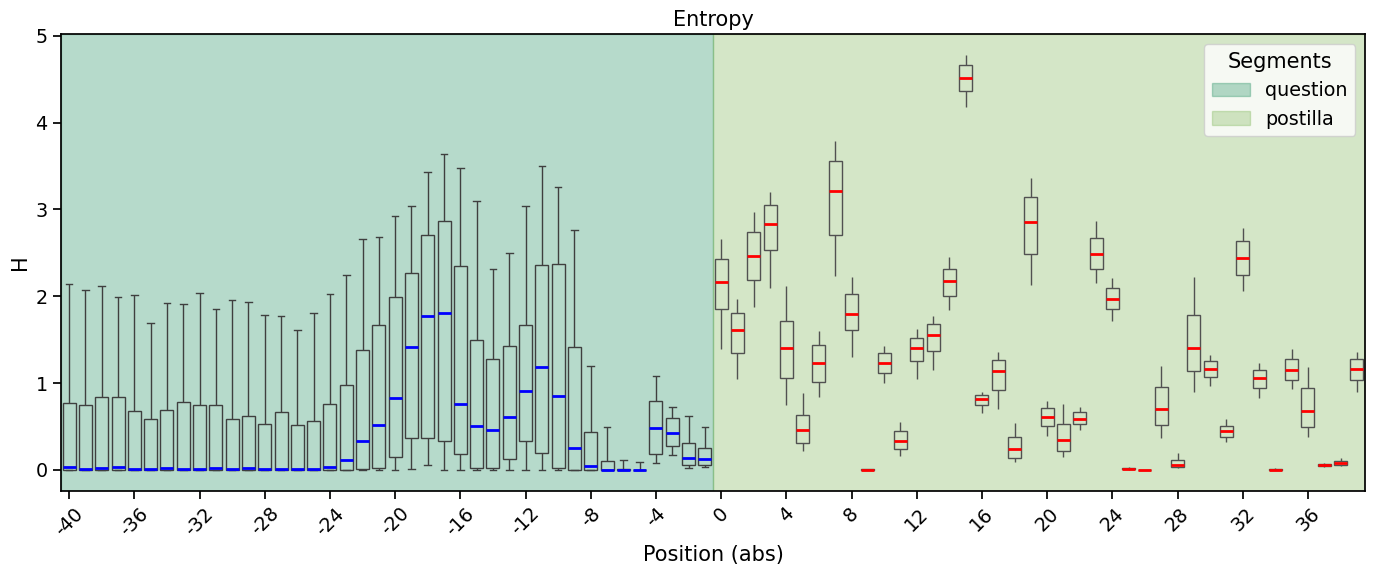

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [73]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

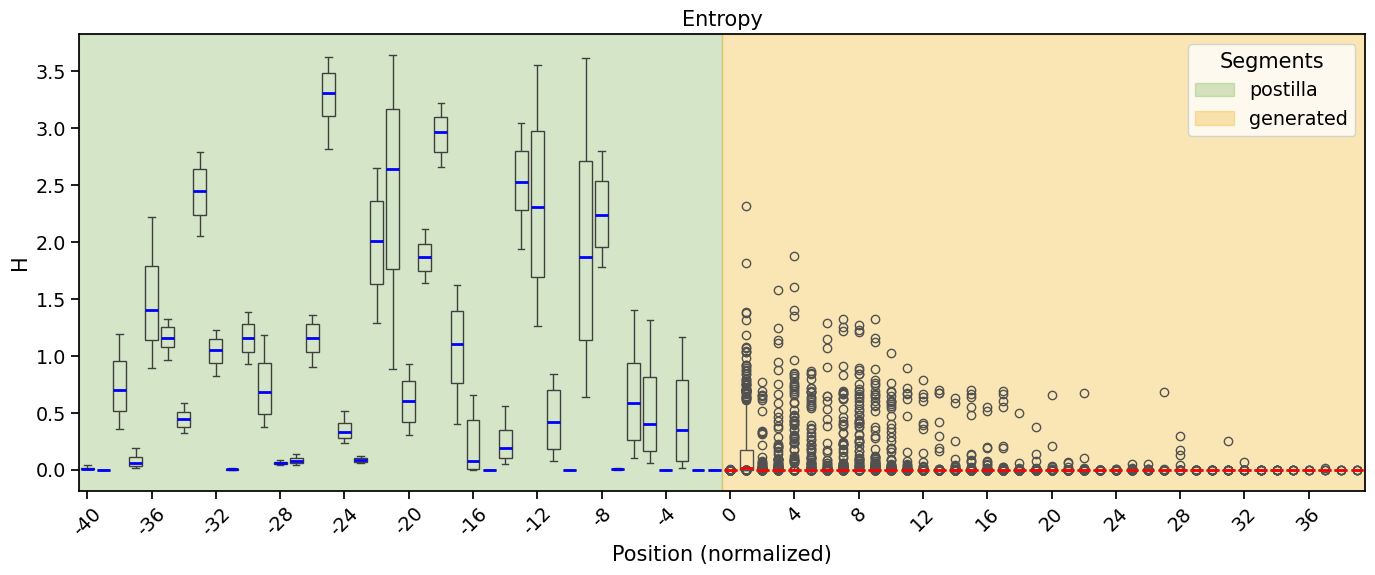

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [75]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_95935/2463233701.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_95935/2463233701.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


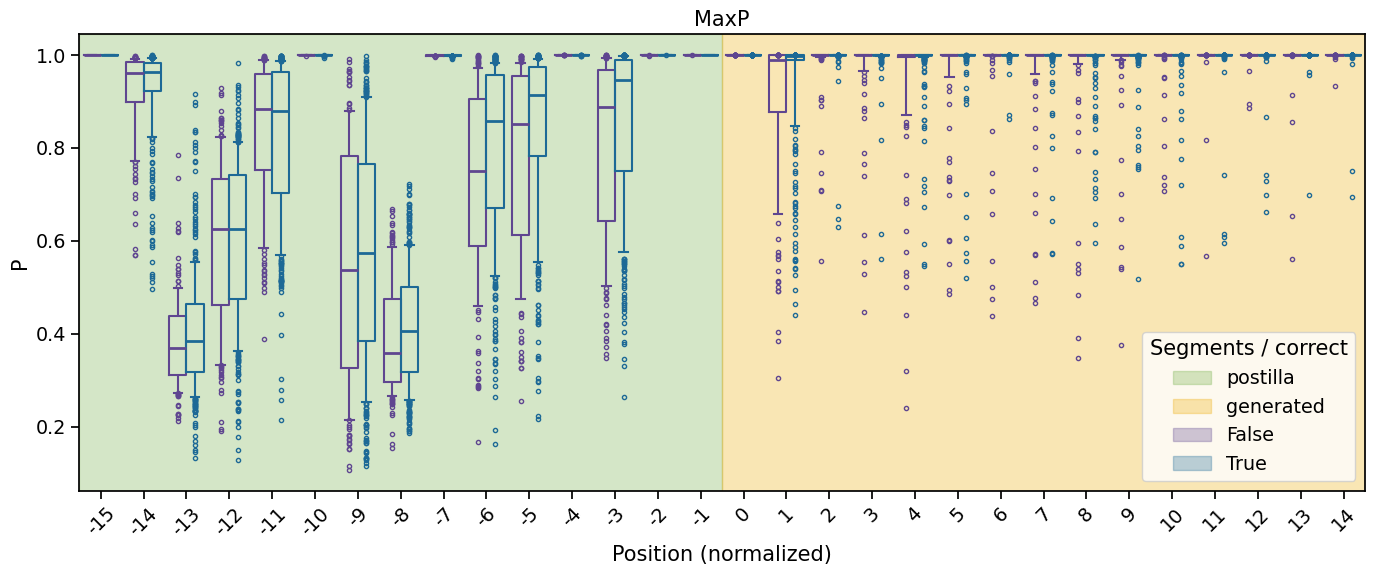

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [77]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_95935/2499406647.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_95935/2499406647.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


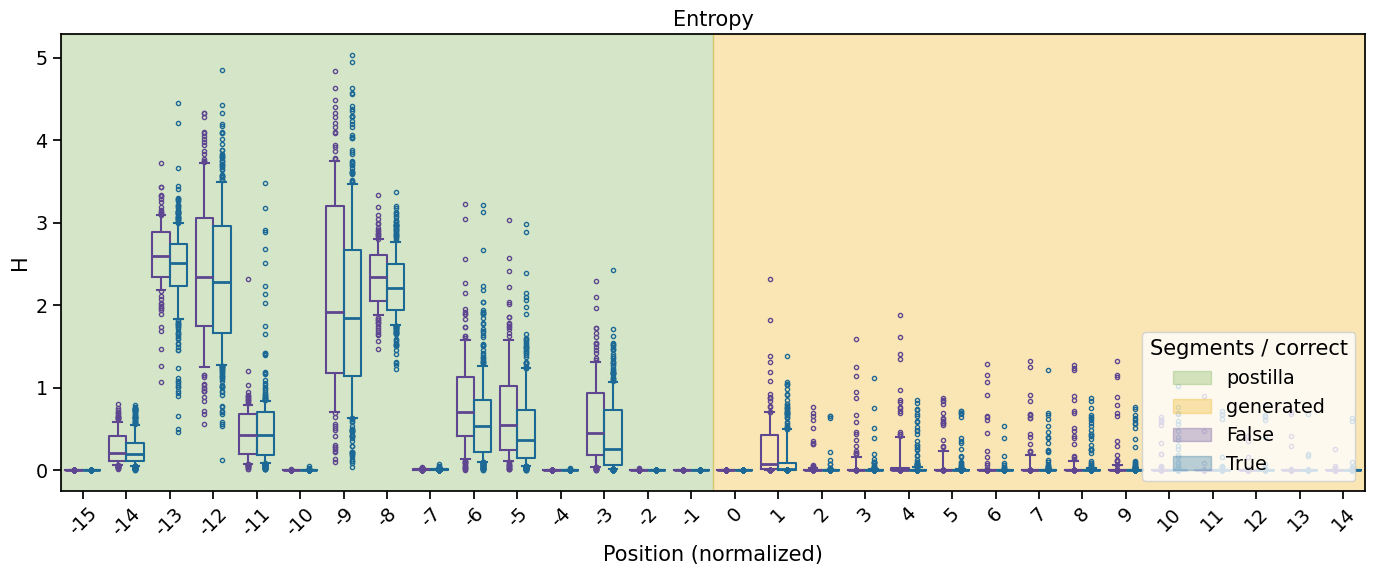

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

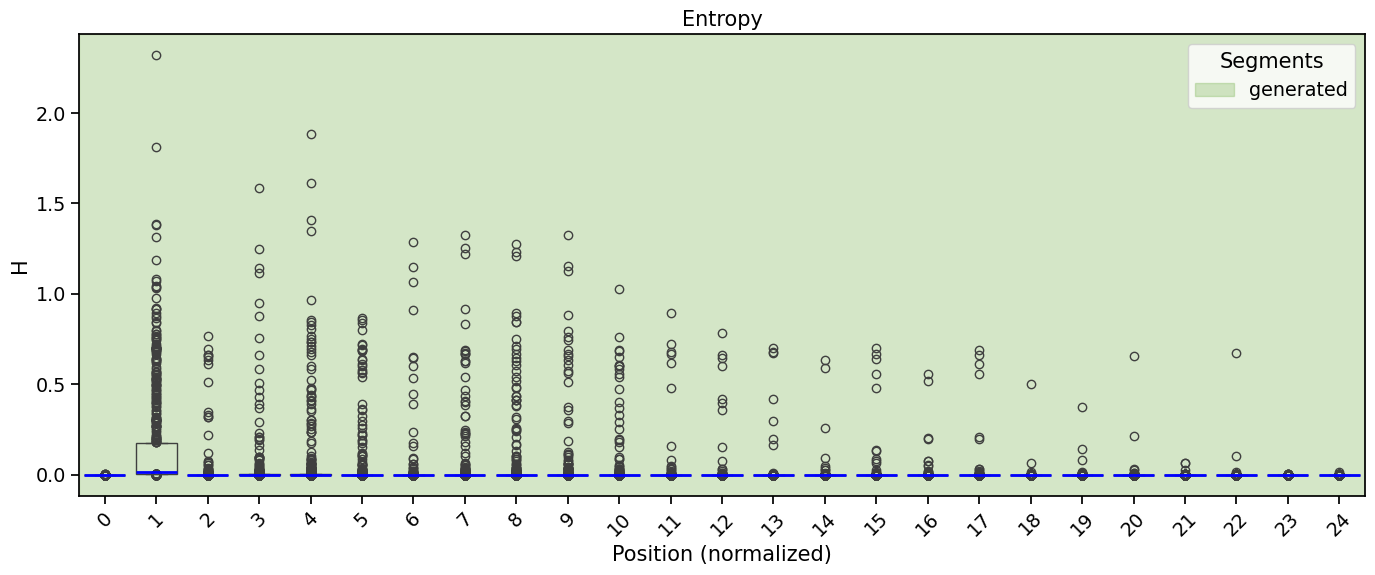

In [79]:
# only generated

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'generated') & (m.tokzero < delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [80]:
m.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [81]:
m[m.segment=='preamble'].groupby('pid').size().std()

0.0

In [82]:
m[m.segment=='instruction'].groupby('pid').size().std()

0.0

In [83]:
m[m.segment=='input'].groupby('pid').size().std()

663.59317099098

In [84]:
m[m.tok_rel_segm_abs<1.].true_ent.var()

5.957321

In [85]:
df[df.tok_bin_idx==0].true_ent.var()

10.003355

99


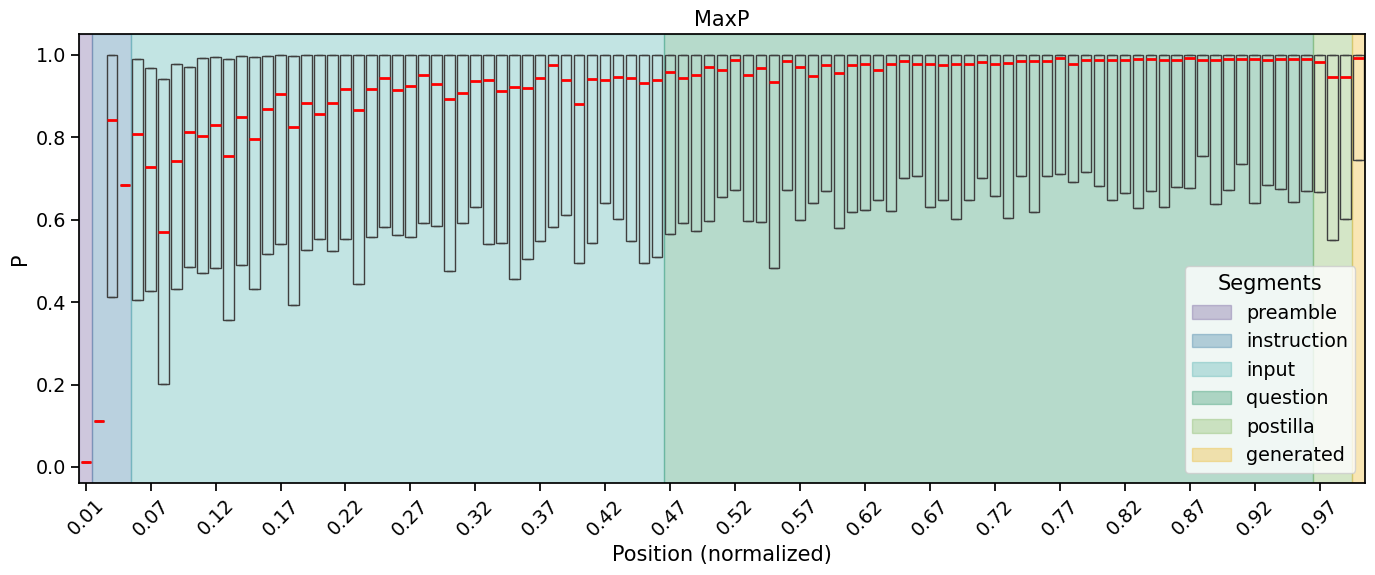

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

99


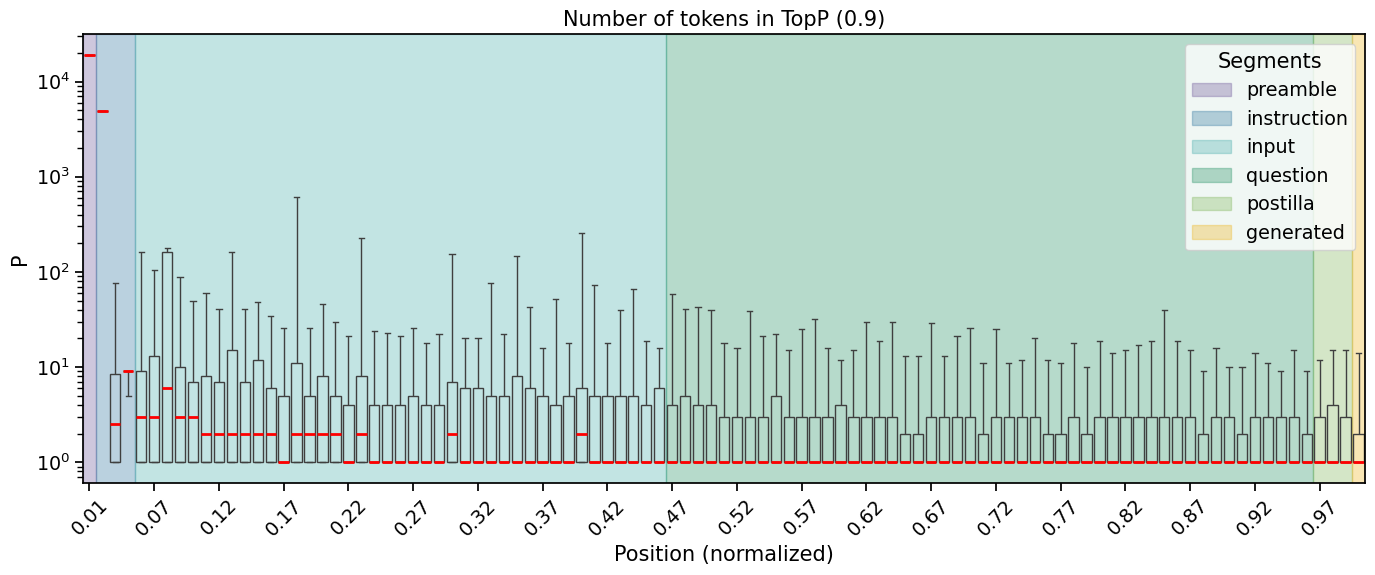

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [88]:
mm[mm.area=='prompt'].true_ent.describe()

count    1.265979e+07
mean     8.318632e-01
std      1.236386e+00
min      0.000000e+00
25%      1.359092e-03
50%      1.887467e-01
75%      1.245379e+00
max      9.495135e+00
Name: true_ent, dtype: float64

In [89]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,12,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,12,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,12,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,12,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,12,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76741907,9,1794,2101,generated,1,2.413767e-07,1.000000,2081,2105,generated,5,24,0.998100,5.833333,20,-5
76741913,9,1794,2102,generated,1,6.011833e-07,1.000000,2081,2105,generated,5,24,0.998575,5.875000,21,-4
76741919,9,1794,2103,generated,1,3.359786e-06,1.000000,2081,2105,generated,5,24,0.999050,5.916667,22,-3
76741925,9,1794,2104,generated,1,1.075896e-06,1.000000,2081,2105,generated,5,24,0.999525,5.958333,23,-2


In [90]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [91]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

0.0

In [92]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.0

In [93]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

14.150655

In [94]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

55.277777777777786

In [95]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

2.3817372905508183

In [96]:
mm[mm.segment=='generated'].sort_values(['pid', 'tok'], ascending=[True,True]).to_excel("delme.xlsx")

### search prompts for which top-p varies

In [97]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [98]:
mv = mm[mm.pid.isin(variators)]

In [99]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

array([  12,   14,   17,   18,   23,   41,   45,   63,   74,   94,   99,
        112,  118,  119,  123,  125,  128,  130,  138,  143,  164,  177,
        181,  182,  188,  190,  194,  195,  209,  216,  218,  221,  224,
        229,  238,  265,  266,  297,  305,  318,  320,  329,  352,  359,
        364,  367,  368,  382,  398,  404,  421,  446,  453,  457,  458,
        474,  476,  484,  486,  492,  493,  496,  507,  511,  521,  533,
        558,  607,  613,  621,  627,  629,  632,  633,  658,  667,  682,
        698,  699,  708,  711,  731,  741,  743,  757,  758,  766,  768,
        771,  777,  782,  785,  790,  805,  810,  823,  829,  839,  842,
        847,  854,  858,  864,  875,  879,  880,  884,  886,  890,  902,
        916,  918,  951,  952,  976,  977,  984,  992,  994, 1004, 1009,
       1011, 1017, 1018, 1023, 1029, 1034, 1065, 1069, 1070, 1071, 1073,
       1077, 1088, 1094, 1098, 1099, 1104, 1107, 1113, 1123, 1126, 1139,
       1140, 1141, 1142, 1145, 1147, 1149, 1156, 11

In [100]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [101]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

array([  12,   14,   17,   18,   23,   41,   45,   63,   74,   79,   94,
         99,  112,  118,  119,  123,  125,  128,  130,  134,  137,  138,
        139,  143,  149,  164,  177,  181,  182,  188,  190,  194,  195,
        200,  209,  216,  218,  221,  224,  229,  238,  265,  266,  297,
        302,  318,  320,  352,  359,  364,  367,  368,  374,  382,  385,
        398,  403,  404,  421,  446,  453,  454,  457,  458,  474,  476,
        484,  486,  492,  493,  496,  507,  511,  521,  533,  558,  590,
        607,  621,  628,  629,  632,  633,  658,  682,  698,  699,  708,
        711,  731,  741,  743,  757,  758,  766,  768,  771,  777,  782,
        785,  790,  792,  805,  810,  823,  829,  830,  834,  839,  840,
        842,  847,  854,  858,  864,  875,  879,  880,  884,  886,  902,
        916,  918,  951,  952,  961,  976,  977,  992,  994, 1009, 1011,
       1017, 1018, 1023, 1028, 1029, 1034, 1037, 1065, 1069, 1070, 1071,
       1073, 1077, 1088, 1094, 1097, 1098, 1099, 11

In [102]:
set(v1) - set(v2)

{305,
 329,
 613,
 627,
 667,
 890,
 984,
 1004,
 1104,
 1107,
 1113,
 1210,
 1288,
 1331,
 1440,
 1548,
 1750}

In [103]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

,pid,correct
0,12,0.2
1,14,0.2
2,17,0.5
3,18,0.2
5,23,0.3
...,...,...
491,1697,0.3
496,1726,0.5
499,1740,0.0
502,1750,1.0


In [104]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

,pid,correct


In [105]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end,tok_bin,tok_bin_hi,tok_bin_lo
12425,0,12,2070,generated,1,9.756351e-07,1.000000,2070,2095,generated,5,25,0.988067,5.000000,0,-26,"(4.98, 5.04]",5.04,4.98
12431,0,12,2071,generated,1,1.799797e-02,0.997829,2070,2095,generated,5,25,0.988544,5.040000,1,-25,"(4.98, 5.04]",5.04,4.98
12437,0,12,2072,generated,1,5.711260e-07,1.000000,2070,2095,generated,5,25,0.989021,5.080000,2,-24,"(5.04, 5.1]",5.10,5.04
12443,0,12,2073,generated,1,1.362268e-05,0.999999,2070,2095,generated,5,25,0.989499,5.120000,3,-23,"(5.1, 5.16]",5.16,5.10
12449,0,12,2074,generated,1,1.221164e-05,0.999999,2070,2095,generated,5,25,0.989976,5.160000,4,-22,"(5.1, 5.16]",5.16,5.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76628183,0,1794,2101,generated,1,2.413767e-07,1.000000,2081,2105,generated,5,24,0.998100,5.833333,20,-5,"(5.82, 5.88]",5.88,5.82
76628189,0,1794,2102,generated,1,6.011833e-07,1.000000,2081,2105,generated,5,24,0.998575,5.875000,21,-4,"(5.82, 5.88]",5.88,5.82
76628195,0,1794,2103,generated,1,3.359786e-06,1.000000,2081,2105,generated,5,24,0.999050,5.916667,22,-3,"(5.88, 5.94]",5.94,5.88
76628201,0,1794,2104,generated,1,1.075896e-06,1.000000,2081,2105,generated,5,24,0.999525,5.958333,23,-2,"(5.94, 6.0]",6.00,5.94


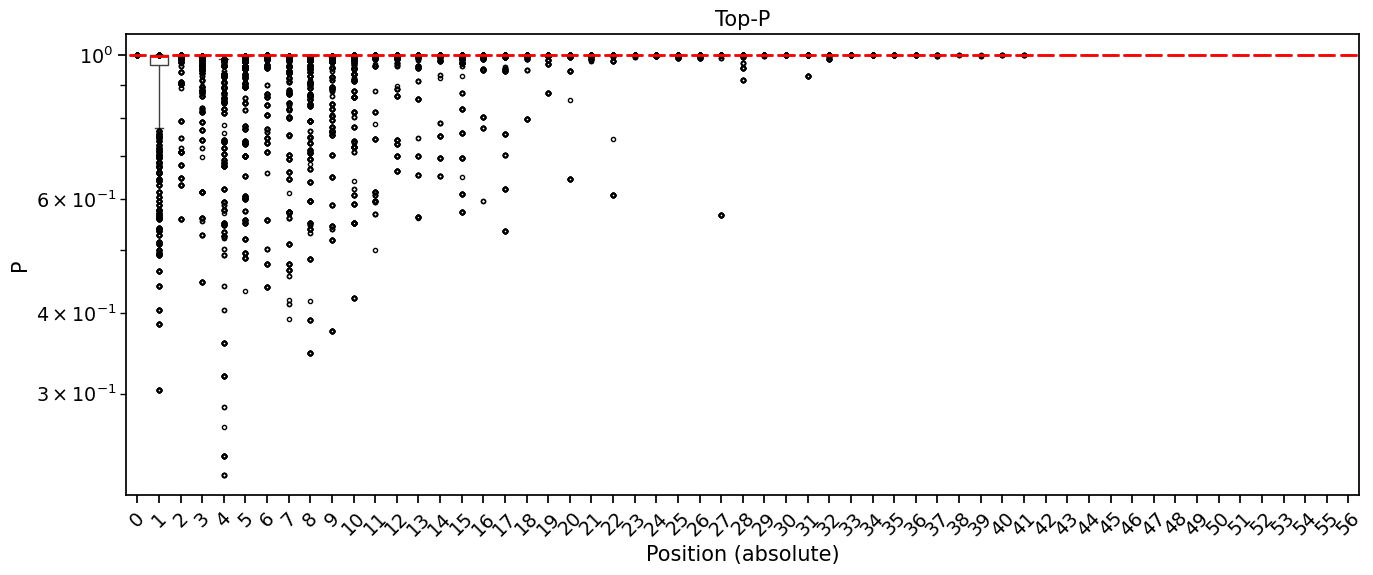

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

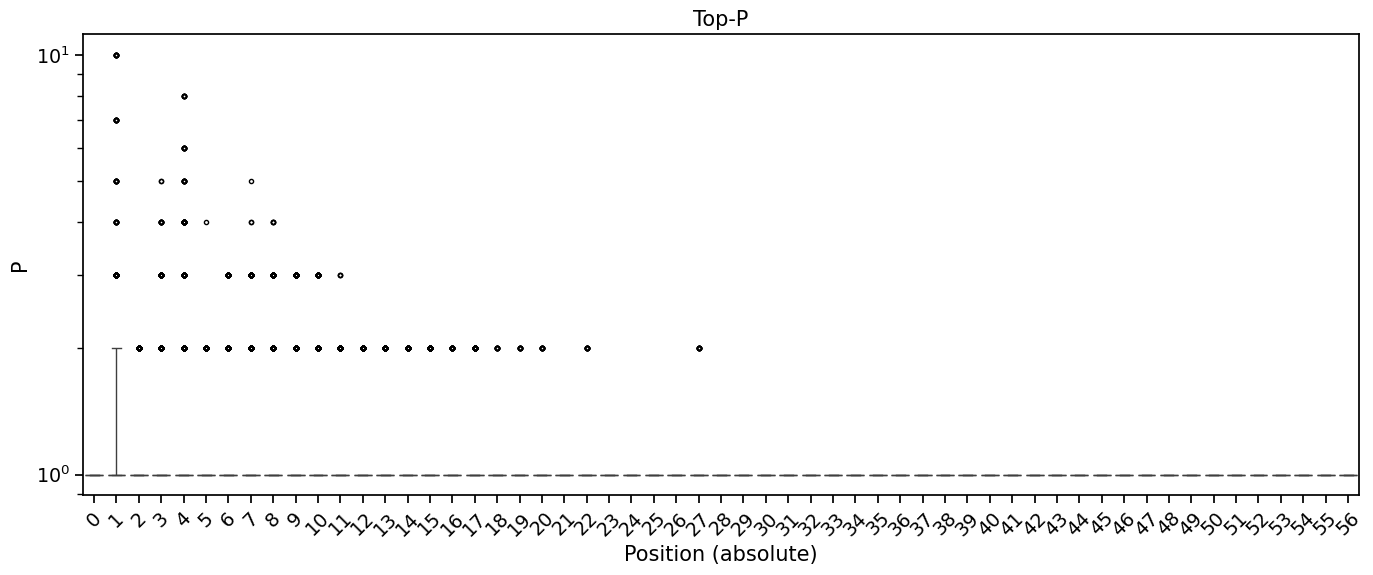

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [108]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
12425,0,12,2070,generated,1,9.756351e-07,1.000000,2070,2095,generated,5,25,0.988067,5.000000,0,-26
12431,0,12,2071,generated,1,1.799797e-02,0.997829,2070,2095,generated,5,25,0.988544,5.040000,1,-25
12437,0,12,2072,generated,1,5.711260e-07,1.000000,2070,2095,generated,5,25,0.989021,5.080000,2,-24
12443,0,12,2073,generated,1,1.362268e-05,0.999999,2070,2095,generated,5,25,0.989499,5.120000,3,-23
12449,0,12,2074,generated,1,1.221164e-05,0.999999,2070,2095,generated,5,25,0.989976,5.160000,4,-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76741907,9,1794,2101,generated,1,2.413767e-07,1.000000,2081,2105,generated,5,24,0.998100,5.833333,20,-5
76741913,9,1794,2102,generated,1,6.011833e-07,1.000000,2081,2105,generated,5,24,0.998575,5.875000,21,-4
76741919,9,1794,2103,generated,1,3.359786e-06,1.000000,2081,2105,generated,5,24,0.999050,5.916667,22,-3
76741925,9,1794,2104,generated,1,1.075896e-06,1.000000,2081,2105,generated,5,24,0.999525,5.958333,23,-2


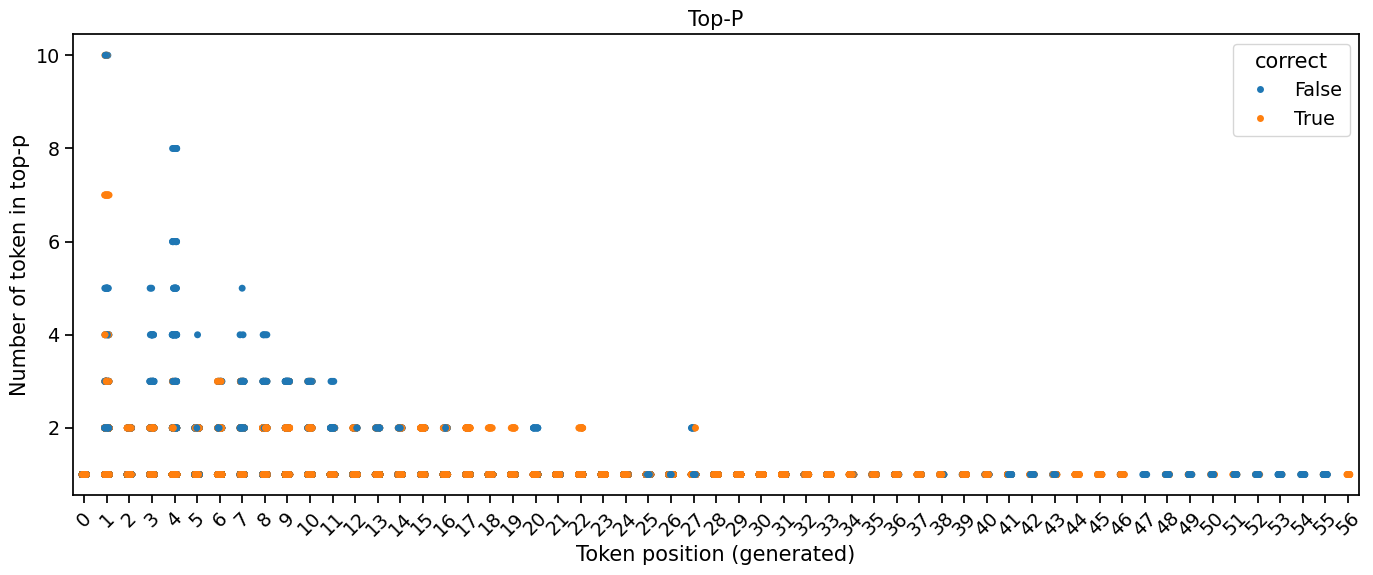

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

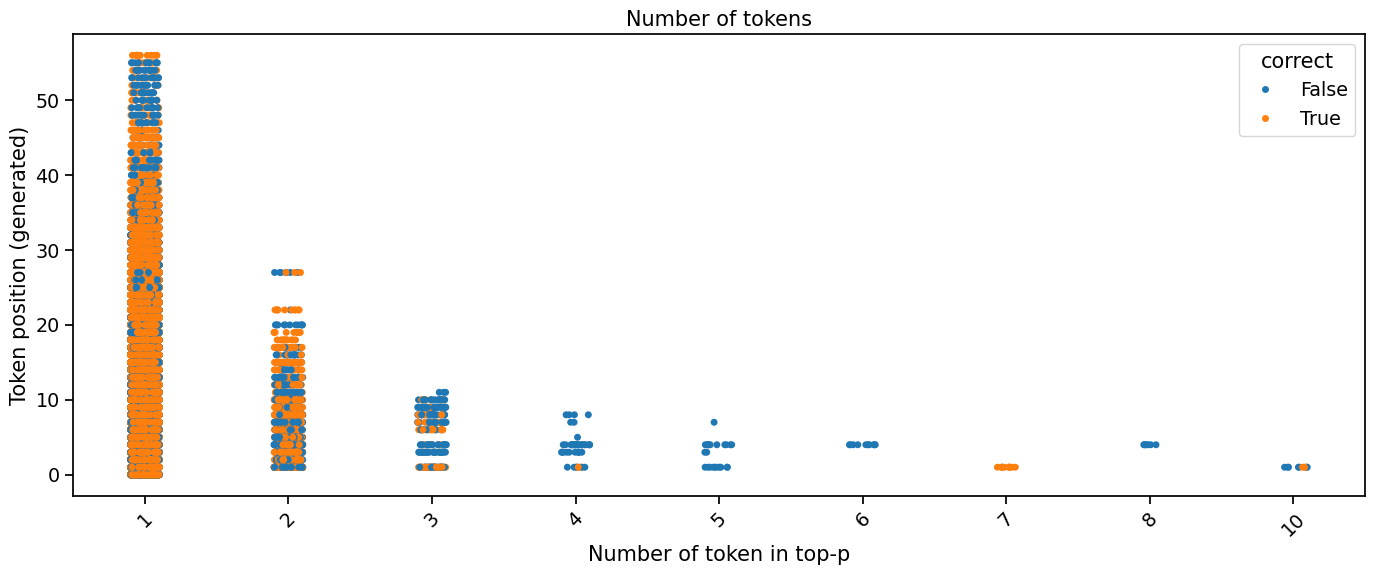

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [111]:
m_.groupby('shape').correct.agg(['count', 'mean'])

,count,mean
shape,,
1,127706,0.720882
2,2460,0.542683
3,258,0.302326
4,48,0.083333
5,23,0.000000
6,10,0.000000
7,10,1.000000
8,7,0.000000
10,10,0.400000


In [112]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

shape
1     0.978350
2     0.018846
3     0.001977
4     0.000368
5     0.000176
6     0.000077
7     0.000077
8     0.000054
10    0.000077
Name: correct, dtype: float64

In [113]:
mm[mm.segment=='generated'].true_ent.describe()

count    1.305320e+05
mean     1.930730e-02
std      1.123360e-01
min      7.314307e-12
25%      4.300027e-07
50%      4.030707e-06
75%      7.277747e-05
max      2.319561e+00
Name: true_ent, dtype: float64

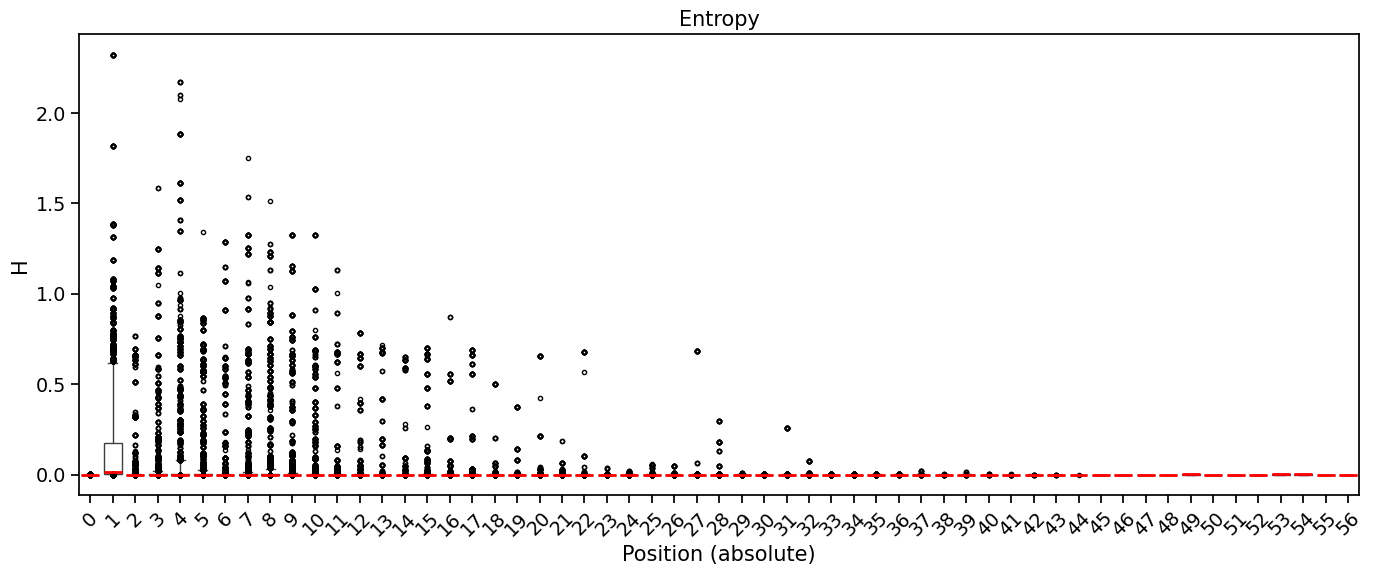

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

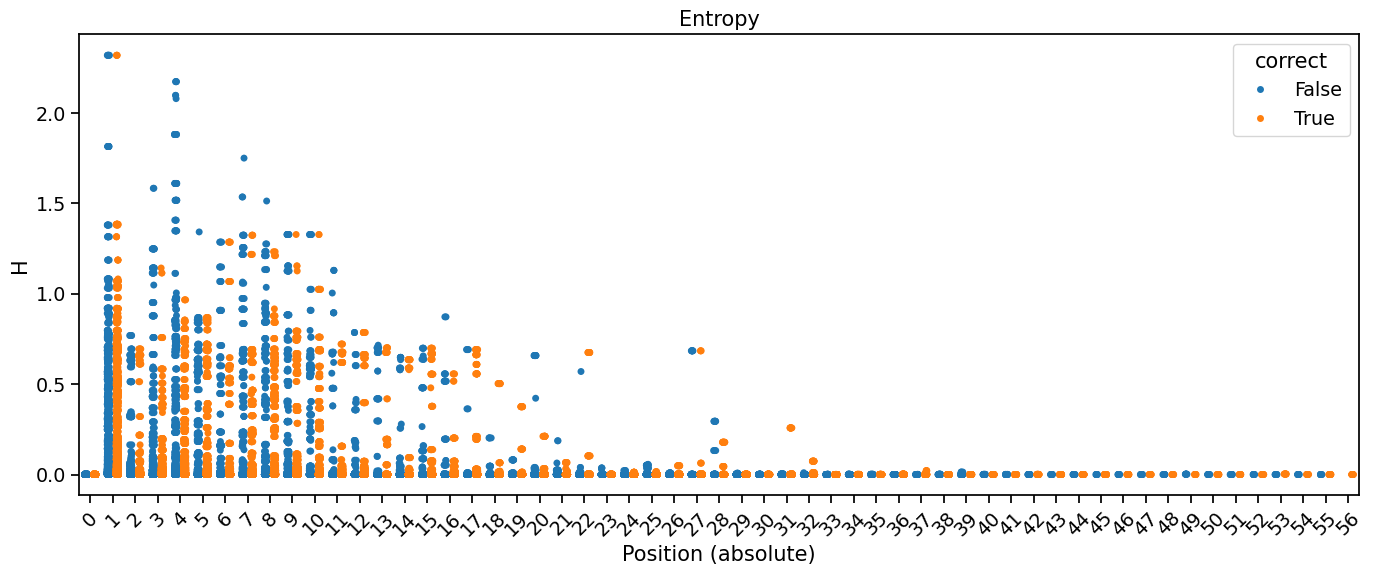

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [116]:
mm[(mm.segment=='generated') & (mm.pid==1)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [117]:
mm[(mm.segment=='generated') & (mm.pid==2)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [118]:
mm.shape

(12790322, 16)

In [119]:
m.shape

(1279032, 19)

In [120]:
# TODO: compare variance in generate (same prompt / multiple prompts)

In [121]:
# TODO: compare observables grouping by truth

In [122]:
# TODO: plot truth vs aggregated uncertainty